Подготовка данных OTTO
В этом ноутбуке мы преобразуем тяжелые `jsonl` файлы в быстрый формат `parquet` с помощью легковесной библиотеки `polars`.

### Пример структуры сырых данных
Каждая строка JSONL выглядит примерно так:
```json
{
  "session": 13,
  "events": [
    {"aid": 1441, "ts": 1659304800, "type": "clicks"},
    {"aid": 1441, "ts": 1659304850, "type": "carts"}
  ]
}
```

In [ ]:
import polars as pl
import os
import orjson
from tqdm import tqdm

DATA_PATH = '/mnt/2878C3AB78C3765A/.Trash-1000/OTTO/'
OUT_PATH = './data_parquet/'

os.makedirs(OUT_PATH, exist_ok=True)

def process_jsonl_to_parquet(file_name, chunk_size=100_000):
    print(f'Обрабатываем {file_name}...')
    file_path = os.path.join(DATA_PATH, file_name)
    out_dir = os.path.join(OUT_PATH, file_name.split('.')[0])
    os.makedirs(out_dir, exist_ok=True)
    
    import gc
    type_labels = {'clicks':0, 'carts':1, 'orders':2}
    
    chunk = 1
    df_data = []
    
    with open(file_path, 'rb') as f:
        for i, line in tqdm(enumerate(f)):
            session_data = orjson.loads(line)
            session_id = session_data['session']
            for event in session_data['events']:
                df_data.append([session_id, event['aid'], event['ts'], type_labels[event['type']]])
            
            if len(df_data) >= chunk_size:
                df = pl.DataFrame(
                    df_data, schema=["session", "aid", "ts", "type"], orient="row", 
                    schema_overrides={"session": pl.Int32, "aid": pl.Int32, "ts": pl.Int64, "type": pl.Int8}
                )
                df.write_parquet(f'{out_dir}/{chunk:03d}.parquet')
                df_data = []
                chunk += 1
                gc.collect()
                
        if len(df_data) > 0:
            df = pl.DataFrame(
                df_data, schema=["session", "aid", "ts", "type"], orient="row", 
                schema_overrides={"session": pl.Int32, "aid": pl.Int32, "ts": pl.Int64, "type": pl.Int8}
            )
            df.write_parquet(f'{out_dir}/{chunk:03d}.parquet')
            
    print(f'Готово для {file_name}\n')

In [ ]:
process_jsonl_to_parquet('test.jsonl')
process_jsonl_to_parquet('train.jsonl')

Обрабатываем test.jsonl...


1671803it [00:20, 81732.85it/s] 


Готово для test.jsonl

Обрабатываем train.jsonl...


12899779it [09:41, 22188.67it/s]

Готово для train.jsonl




Загрузим один из чанков (например, первый кусок `train`), чтобы познакомиться с форматом `Parquet` и данными.

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns


df = pl.read_parquet('./data_parquet/train/001.parquet')
print(f'Размер одного чанка: {df.shape}')
display(df.head(10))

Размер одного чанка: (100042, 4)


session,aid,ts,type
i32,i32,i64,i8
0,1517085,1659304800025,0
0,1563459,1659304904511,0
0,1309446,1659367439426,0
0,16246,1659367719997,0
0,1781822,1659367871344,0
0,1152674,1659367885796,0
0,1649869,1659369893840,1
0,461689,1659369898050,1
0,305831,1659370027105,2


**Объяснение колонок:**
- `session`: уникальный идентификатор пользователя (сессии).
- `aid`: Article ID товара.
- `ts`: время в миллисекундах.
- `type`: тип события (0 - click, 1 - cart, 2 - order).

In [ ]:
event_counts = df.group_by('type').agg(pl.len().alias('count')).sort('type')
print("0: clicks, 1: carts, 2: orders")
display(event_counts)

0: clicks, 1: carts, 2: orders


type,count
i8,u32
0,90055
1,7943
2,2044


Статистика по длине сессий:


statistic,value
str,f64
"""count""",1257.0
"""null_count""",0.0
"""mean""",79.587908
"""std""",94.72488
"""min""",2.0
"""25%""",11.0
"""50%""",41.0
"""75%""",114.0
"""max""",482.0


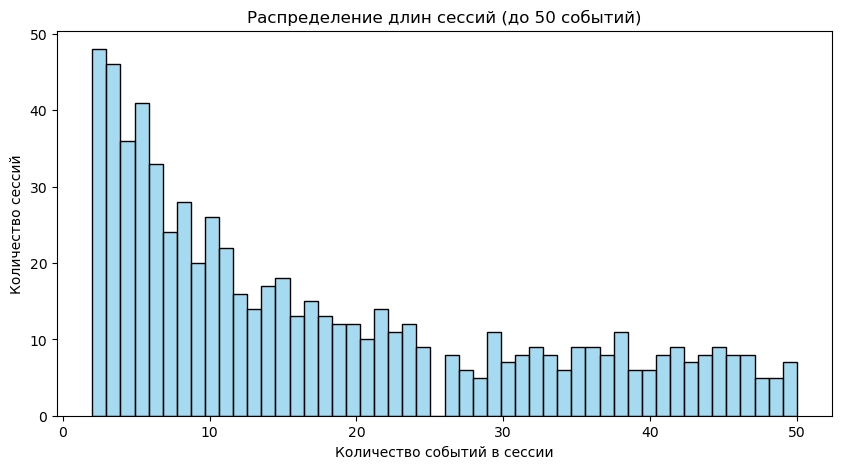

In [ ]:
session_lengths = df.group_by('session').agg(pl.len().alias('length'))
print("Статистика по длине сессий:")
display(session_lengths['length'].describe())

plt.figure(figsize=(10, 5))
lens = session_lengths.filter(pl.col('length') <= 50)['length'].to_numpy()
sns.histplot(lens, bins=50, color='skyblue', edgecolor='black')
plt.title('Распределение длин сессий (до 50 событий)')
plt.xlabel('Количество событий в сессии')
plt.ylabel('Количество сессий')
plt.show()